### A data science project exploring the relationship between weather, geographic location and happiness in the UK

### Import all required libraries

In [1651]:
import re
import time
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

import sklearn as sk
import sklearn.cluster as skc
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

### Extract the data from the Met Office Historic Station Data webpage

In [2]:
# A function to extract the Latitude / Longitude of a station from the Met Office Historic Station Data webpage
def getLL(soup_text):
    splitText = (soup_text.split('Lat'))
    cleanData = re.sub('[^0-9(-.)\s]+', '', splitText[1])
    addComma = re.sub('\s+', ',', cleanData.strip())
    data = addComma.split(',')
    lat = float(data[0])
    lon = float(data[1])
    return lat, lon

# A function to extract the weather station data from the Met Office Historic Station Data webpage
def getWeather(soup_text):
    splitText = (soup_text.split('hours\r\n'))
    dataOnly = splitText[1]
    cleanData = re.sub('[A-Za-z*#$|]+', '', dataOnly)
    dataList = (cleanData.split('\r\n'))
    delimData = []
    for item in dataList:
        addComma = re.sub('\s+', ',', item.strip())
        delimData.append(addComma)
    return delimData

In [8]:
# Create a dictionary which stores a DataFrame of data for each station
print('Creating weather data dictionary...')

allFrames = {}
stations = open('stations.txt')
for name in stations:
    url = 'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/' + name.rstrip()  + 'data.txt'
    agent = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36' 
             '(KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
    page = requests.get(url, headers=agent)
    soup = BeautifulSoup(page.text)
    text = soup.get_text()
    
    lat, lon = getLL(text)
    data = getWeather(text)
    
    df = pd.DataFrame([item.split(',') for item in data], 
                      columns=['Year', 'Month', 'Max Temp', 'Min Temp', 
                               'Air Frost', 'Total Rain', 'Total Sun'])
    df = df.apply(pd.to_numeric, errors='coerce')
    
    nameCap = (name.rstrip()).capitalize()
    df.insert(0, 'Lon', lon)
    df.insert(0, 'Lat', lat)
    df.insert(0, 'Station', nameCap)
    
    allFrames[nameCap] = df
    
    time.sleep(1)

stations.close()

print('Weather data dictionary created.')

Creating weather data dictionary...
Weather data dictionary created.


In [9]:
# View the dictionary of DataFrames
allFrames

{'Aberporth':        Station     Lat   Lon  Year  Month  Max Temp  Min Temp  Air Frost  \
 0    Aberporth  52.139 -4.57  1941      1       NaN       NaN        NaN   
 1    Aberporth  52.139 -4.57  1941      2       NaN       NaN        NaN   
 2    Aberporth  52.139 -4.57  1941      3       NaN       NaN        NaN   
 3    Aberporth  52.139 -4.57  1941      4       NaN       NaN        NaN   
 4    Aberporth  52.139 -4.57  1941      5       NaN       NaN        NaN   
 ..         ...     ...   ...   ...    ...       ...       ...        ...   
 949  Aberporth  52.139 -4.57  2020      2       9.0       4.4        0.0   
 950  Aberporth  52.139 -4.57  2020      3       9.9       4.0        0.0   
 951  Aberporth  52.139 -4.57  2020      4      14.8       7.0        0.0   
 952  Aberporth  52.139 -4.57  2020      5      16.8       8.6        0.0   
 953  Aberporth  52.139 -4.57  2020      6      17.0      11.2        0.0   
 
      Total Rain  Total Sun  
 0          74.7        NaN  
 

### Clean, structure and store the data

In [498]:
# Concatenate all DataFrames in the dictionary into one DataFrame
df_weather = pd.concat([df for df in allFrames.values()], ignore_index=True)
df_weather

,Station,Lat,Lon,Year,Month,Max Temp,Min Temp,Air Frost,Total Rain,Total Sun
0,Aberporth,52.139,-4.570,1941.0,1.0,NaN,NaN,NaN,74.7,NaN
1,Aberporth,52.139,-4.570,1941.0,2.0,NaN,NaN,NaN,69.1,NaN
2,Aberporth,52.139,-4.570,1941.0,3.0,NaN,NaN,NaN,76.2,NaN
3,Aberporth,52.139,-4.570,1941.0,4.0,NaN,NaN,NaN,33.7,NaN
4,Aberporth,52.139,-4.570,1941.0,5.0,NaN,NaN,NaN,51.3,NaN
...,...,...,...,...,...,...,...,...,...,...
37768,Yeovilton,51.006,-2.641,2020.0,2.0,10.8,4.5,2.0,117.4,63.1
37769,Yeovilton,51.006,-2.641,2020.0,3.0,11.5,3.0,6.0,43.4,159.2
37770,Yeovilton,51.006,-2.641,2020.0,4.0,17.5,5.3,3.0,39.8,235.0
37771,Yeovilton,51.006,-2.641,2020.0,5.0,19.7,6.8,2.0,3.6,305.6


In [499]:
# Check the location of any empty values
df_weather.isna().sum()

Station          0
Lat              0
Lon              0
Year             6
Month            6
Max Temp       934
Min Temp       908
Air Frost     2333
Total Rain     879
Total Sun     8634
dtype: int64

In [500]:
# View the empty values that are not appropriate to be filled with the mean column value
df_weather[(df_weather['Year'].isna())]

,Station,Lat,Lon,Year,Month,Max Temp,Min Temp,Air Frost,Total Rain,Total Sun
8906,Cwmystwyth,52.358,-3.802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8907,Cwmystwyth,52.358,-3.802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24184,Ringway,53.356,-2.279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24185,Ringway,53.356,-2.279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29548,Southampton,50.898,-1.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29549,Southampton,50.898,-1.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [501]:
# It can be seen that these are empty records, so drop them from the Dataframe 
df_weather.dropna(subset=['Year'], inplace=True)

In [502]:
# Check the location of any remaining empty values
df_weather.isna().sum()

Station          0
Lat              0
Lon              0
Year             0
Month            0
Max Temp       928
Min Temp       902
Air Frost     2327
Total Rain     873
Total Sun     8628
dtype: int64

In [503]:
# Impute mean column values to fill remaining empty values, as K-means cannot handle NaN values
df_weather.fillna(df.mean(), inplace=True) 

# Check if all empty values have been filled
df_weather.isna().sum()

Station       0
Lat           0
Lon           0
Year          0
Month         0
Max Temp      0
Min Temp      0
Air Frost     0
Total Rain    0
Total Sun     0
dtype: int64

In [504]:
# View the DataFrame info to check details such as Dtypes
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37767 entries, 0 to 37772
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     37767 non-null  object 
 1   Lat         37767 non-null  float64
 2   Lon         37767 non-null  float64
 3   Year        37767 non-null  float64
 4   Month       37767 non-null  float64
 5   Max Temp    37767 non-null  float64
 6   Min Temp    37767 non-null  float64
 7   Air Frost   37767 non-null  float64
 8   Total Rain  37767 non-null  float64
 9   Total Sun   37767 non-null  float64
dtypes: float64(9), object(1)
memory usage: 3.2+ MB


In [505]:
# Export DataFrame to csv for storage
df_weather.to_csv('weatherdata.csv')

### Initial data exploration

In [506]:
# View summary stats for all weather data
df_weather.describe()

,Lat,Lon,Year,Month,Max Temp,Min Temp,Air Frost,Total Rain,Total Sun
count,37767.000000,37767.000000,37767.000000,37767.000000,37767.000000,37767.000000,37767.000000,37767.000000,37767.000000
mean,53.953119,-2.734734,1969.117563,6.487171,12.785356,5.936629,3.549765,72.639315,120.758077
std,2.504756,2.217897,36.768205,3.452385,4.983813,4.010256,5.035368,47.762255,55.767414
min,50.218000,-6.880000,1853.000000,1.000000,-0.900000,-8.600000,0.000000,0.000000,2.800000
25%,51.761000,-4.430000,1949.000000,3.000000,8.600000,2.700000,0.000000,39.650000,77.600000
50%,53.381000,-2.584000,1976.000000,6.000000,12.600000,5.700000,1.000000,61.300000,127.917768
75%,55.311000,-1.262000,1998.000000,9.000000,16.700000,9.400000,5.000000,93.800000,147.900000
max,60.139000,1.727000,2020.000000,12.000000,28.300000,17.000000,31.000000,568.800000,350.300000


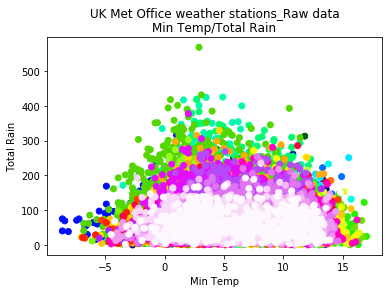

In [507]:
# Make an exploratory plot of a subset of the data 
# In this case: Min Temp/Total Rain with station shown by colour

# Encode non-numeric values as numeric so they can be plotted
stations = np.ravel(df_weather[['Station']])
encoder = preprocessing.LabelEncoder()
encoder.fit(stations)
encNames = encoder.transform(stations)

# Plot the data
X = df_weather[['Min Temp', 'Total Rain']].to_numpy()
y = encNames
plt.scatter(X[:,0] ,X[:,1], c=y, cmap='gist_ncar')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations_Raw data\nMin Temp/Total Rain')
plt.show()

In [508]:
# Isolate summary stats for a specific station
df_weather[df_weather['Station'].isin(['Nairn'])].describe()

,Lat,Lon,Year,Month,Max Temp,Min Temp,Air Frost,Total Rain,Total Sun
count,1.074000e+03,1.074000e+03,1074.000000,1074.00000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000
mean,5.759300e+01,-3.821000e+00,1975.251397,6.48324,11.994617,4.931531,4.438620,52.853106,108.540248
std,6.397864e-13,6.042427e-14,25.849268,3.45362,4.473318,3.826248,5.547156,28.648767,51.592801
min,5.759300e+01,-3.821000e+00,1931.000000,1.00000,2.200000,-4.300000,0.000000,4.400000,15.600000
25%,5.759300e+01,-3.821000e+00,1953.000000,3.00000,8.200000,1.800000,0.000000,32.225000,64.725000
50%,5.759300e+01,-3.821000e+00,1975.000000,6.00000,11.900000,4.600000,2.000000,48.900000,108.400000
75%,5.759300e+01,-3.821000e+00,1998.000000,9.00000,15.900000,8.400000,7.000000,67.900000,142.150000
max,5.759300e+01,-3.821000e+00,2020.000000,12.00000,22.000000,12.400000,26.000000,222.400000,249.100000


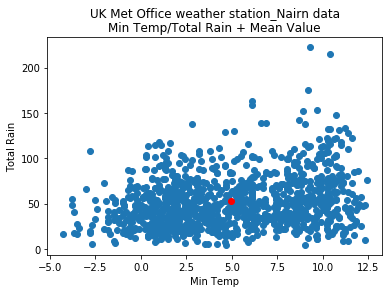

In [509]:
# Make an exploratory plot of a subset of this data
# In this case: Min Temp/Total Rain for Nairn only, with the mean value shown in red

X = df_weather[df_weather['Station'].isin(['Nairn'])][['Min Temp', 'Total Rain']].to_numpy()
dataMean = df_weather[df_weather['Station'].isin(['Nairn'])][['Min Temp', 'Total Rain']].mean().to_numpy()
plt.scatter(X[:,0], X[:,1])
plt.scatter(dataMean[0], dataMean[1], color='r')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather station_Nairn data\nMin Temp/Total Rain + Mean Value')
plt.show()

In [510]:
# Aggregate specific statistics from the whole data set
df_weather.agg({'Max Temp': ['min', 'max', 'median', 'mean'], 
                'Min Temp': ['min', 'max', 'median', 'mean'],
                'Total Rain': ['min', 'max', 'median', 'mean'],
               'Total Sun': ['min', 'max', 'median', 'mean']})

,Max Temp,Min Temp,Total Rain,Total Sun
min,-0.900000,-8.600000,0.000000,2.800000
max,28.300000,17.000000,568.800000,350.300000
median,12.600000,5.700000,61.300000,127.917768
mean,12.785356,5.936629,72.639315,120.758077


In [511]:
# Isolate all data from a specific year only
df_weather[df_weather.Year == 2000]

,Station,Lat,Lon,Year,Month,Max Temp,Min Temp,Air Frost,Total Rain,Total Sun
708,Aberporth,52.139,-4.570,2000.0,1.0,7.8,3.6,3.0,54.4,51.9
709,Aberporth,52.139,-4.570,2000.0,2.0,8.6,4.3,1.0,107.0,96.3
710,Aberporth,52.139,-4.570,2000.0,3.0,9.3,4.7,0.0,28.8,138.5
711,Aberporth,52.139,-4.570,2000.0,4.0,10.3,4.2,0.0,87.6,159.9
712,Aberporth,52.139,-4.570,2000.0,5.0,14.4,8.3,0.0,58.4,230.9
...,...,...,...,...,...,...,...,...,...,...
37534,Yeovilton,51.006,-2.641,2000.0,8.0,21.8,12.4,0.0,44.6,192.2
37535,Yeovilton,51.006,-2.641,2000.0,9.0,19.1,11.0,0.0,80.8,119.6
37536,Yeovilton,51.006,-2.641,2000.0,10.0,14.4,7.1,1.0,162.4,94.6
37537,Yeovilton,51.006,-2.641,2000.0,11.0,10.8,3.8,4.0,119.0,65.7


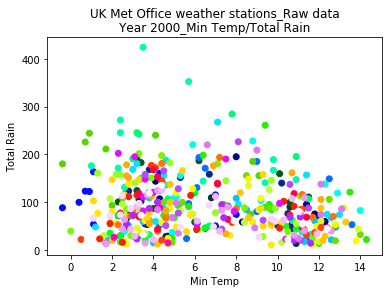

In [512]:
# Make an exploratory plot of a subset of the data 
# In this case: Min Temp/Total Rain data for the year 2000 only, with station shown by colour

# Encode non-numeric values as numeric so they can be plotted
stations = np.ravel(df_weather[df_weather.Year == 2000][['Station']])
encoder = preprocessing.LabelEncoder()
encoder.fit(stations)
encNames = encoder.transform(stations)

# Plot the data
X = df_weather[df_weather.Year == 2000][['Min Temp', 'Total Rain']].to_numpy()
y = encNames
plt.scatter(X[:,0] ,X[:,1], c=y, cmap='gist_ncar')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations_Raw data\nYear 2000_Min Temp/Total Rain')
plt.show()

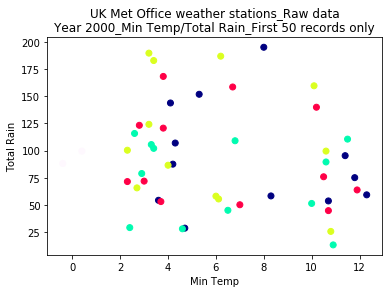

In [513]:
# Make an exploratory plot of a subset of the data 
# In this case: Min Temp/Total Rain data, year 2000 only, first 50 records only, with station shown by colour

# Encode non-numeric values as numeric so they can be plotted
stations = np.ravel(df_weather[df_weather.Year == 2000][['Station']])[:50]
encoder = preprocessing.LabelEncoder()
encoder.fit(stations)
encNames = encoder.transform(stations)

# Plot the data
X = df_weather[df_weather.Year == 2000][['Min Temp', 'Total Rain']][:50].to_numpy()
y = encNames
plt.scatter(X[:,0] ,X[:,1], c=y, cmap='gist_ncar')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations_Raw data\nYear 2000_Min Temp/Total Rain_First 50 records only')

# Plot the mean value of a specific station
#j = df_weather[df_weather['Station'].isin(['Aberporth'])][['Min Temp', 'Total Rain']].mean().to_numpy()
#plt.scatter(j[0], j[1], color='navy', marker='*')

plt.show()

In [514]:
# Aggregate specific statistics for a certain year only
df_weather[df_weather.Year == 2000].agg({'Max Temp': ['min', 'max', 'median', 'mean'], 
                'Min Temp': ['min', 'max', 'median', 'mean'],
                'Total Rain': ['min', 'max', 'median', 'mean'],
               'Total Sun': ['min', 'max', 'median', 'mean']})

,Max Temp,Min Temp,Total Rain,Total Sun
min,5.000000,-0.400000,10.400000,11.100000
max,23.200000,14.300000,424.400000,313.200000
median,12.100000,5.700000,82.400000,127.917768
mean,13.158819,6.517294,92.961763,121.610532


### Testing approaches for K-means clustering analysis

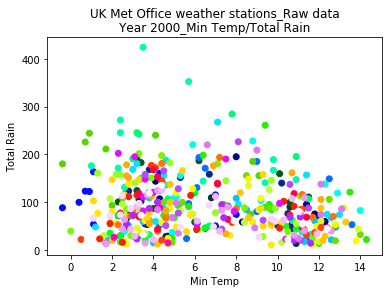

In [515]:
# Prepare test data subset to be analysed
# In this case: Min Temp/Total Rain data for the year 2000 only, with station shown by colour

# Encode non-numeric data as numeric so it can be plotted
stations = np.ravel(df_weather[df_weather.Year == 2000][['Station']])
encoder = preprocessing.LabelEncoder()
encoder.fit(stations)
encStations = encoder.transform(stations)

# Plot the data
X = df_weather[df_weather.Year == 2000][['Min Temp', 'Total Rain']].to_numpy()
y = encStations
plt.scatter(X[:,0] ,X[:,1], c=y, cmap='gist_ncar')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations_Raw data\nYear 2000_Min Temp/Total Rain')
plt.show()

In [516]:
# Create a K-means model, specifing the amount of clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [517]:
# Print the locations of the cluster centres
print(kmeans.cluster_centers_)

[[  6.38383234  99.40479042]
 [  5.35454545 186.52386364]
 [  7.20957214  41.24259453]]


In [518]:
# Print the K-means label number assigned to each piece of data in the array
print(kmeans.labels_)

[2 0 2 0 2 2 0 2 0 1 1 1 2 0 2 0 2 2 2 0 0 0 0 0 2 0 0 0 2 2 2 0 1 1 1 1 0
 0 2 0 2 0 2 2 0 1 1 0 0 0 2 0 2 2 0 0 0 1 1 0 2 0 2 0 0 2 2 2 1 1 1 1 2 2
 2 0 0 2 2 2 2 0 0 2 2 1 2 1 0 2 0 0 1 1 1 1 2 0 2 0 0 2 0 0 0 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 0 2 2 0 2 0 1 1 0 1 2 2 2 1 2 0 2 2 0 0 1 0 2 2 2 0
 0 2 2 2 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 2 2 2 0 0 2 2 2 0 1 0 0 2 0 2 1 0
 2 2 2 0 1 1 1 1 1 1 0 2 0 2 0 1 1 1 0 2 2 2 0 0 2 2 2 0 0 0 0 2 2 2 0 0 2
 2 2 0 0 0 2 2 2 2 0 0 2 2 2 2 1 0 2 2 2 2 0 2 2 2 2 2 0 0 0 0 0 2 0 2 0 2
 2 1 1 1 1 2 0 2 0 2 2 2 2 0 0 0 0 1 1 0 2 2 2 2 0 1 1 0 1 2 0 2 2 0 0 2 2
 0 1 1 0 2 2 2 1 2 2 2 2 0 0 1 1 2 2 2 0 2 2 0 0 0 0 0 0 2 0 2 1 2 2 2 2 0
 0 1 0 2 0 2 1 1 0 0 2 0 2 0 0 1 0 1 2 2 2 0 2 2 2 2 2 0 0 0 0 1 0 2 2 2 2
 0 0 1 0 1 0 0 2 2 2 2 0 0 0 1 1 0 2 2 2 0 0 2 2 2 0 0 0 2 2 2 2 0 2 2 0 2
 0 0 2 0 0 2 0 0 2 2 2 2 2 0 0 0 2 0 2 0 2 2 2 2 0 1 0 0]


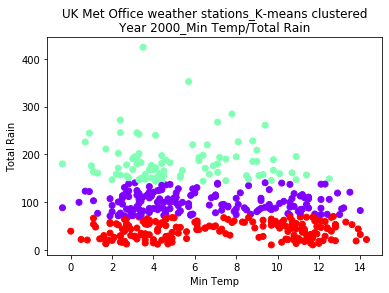

In [519]:
# Plot the data again, this time showing the K-means clusters as different colours
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations_K-means clustered\nYear 2000_Min Temp/Total Rain')
plt.show()

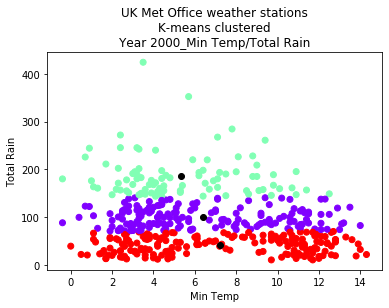

In [520]:
# Plot the data again, this time also plotting the cluster centre points
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations\nK-means clustered\nYear 2000_Min Temp/Total Rain')
plt.show()

In [521]:
# Scale the data to deal with the difference between the axes values
X_scaled = preprocessing.scale(X)
X_scaled

array([[-7.94677239e-01, -6.44167121e-01],
       [-6.03995729e-01,  2.34506148e-01],
       [-4.95034866e-01, -1.07181039e+00],
       [-6.31235945e-01, -8.95672632e-02],
       [ 4.85612901e-01, -5.77347861e-01],
       [ 1.13937808e+00, -6.54190010e-01],
       [ 1.43902045e+00, -2.96706969e-01],
       [ 1.57522153e+00, -5.60643046e-01],
       [ 1.33005959e+00,  4.07302938e-02],
       [ 4.03892254e-01,  1.70452987e+00],
       [-3.31593572e-01,  9.82881860e-01],
       [-6.58476161e-01,  8.49243340e-01],
       [-1.12155983e+00, -1.06345798e+00],
       [-9.85358750e-01, -2.33228672e-01],
       [-5.22275082e-01, -1.08183327e+00],
       [-8.76397887e-01,  2.11119407e-01],
       [-4.71098245e-03, -7.97851419e-01],
       [ 9.48696569e-01, -6.92611085e-01],
       [ 1.19385851e+00, -1.32906454e+00],
       [ 1.35729981e+00,  2.94643482e-01],
       [ 1.11213786e+00, -5.61576332e-02],
       [ 7.70096648e-02,  2.69586259e-01],
       [-8.49157671e-01,  1.52652554e-01],
       [-1.

In [522]:
# Run the K-means model on the scaled data
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

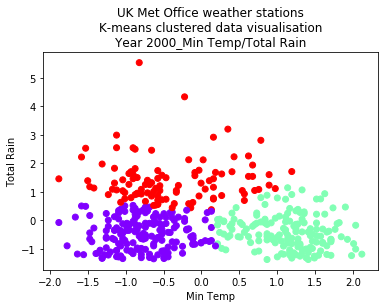

In [523]:
# Plot the scaled data and the new clusters
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans.labels_, cmap='rainbow')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations\nK-means clustered data visualisation\nYear 2000_Min Temp/Total Rain')
plt.show()

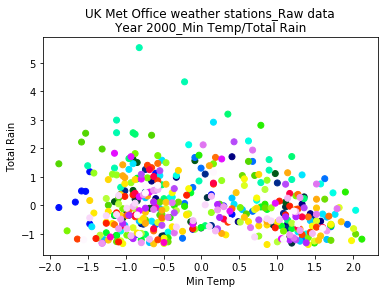

In [531]:
# Plot the scaled data showing the stations by colour
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='gist_ncar')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations_Raw data\nYear 2000_Min Temp/Total Rain')
plt.show()

### Prepare a data subset for analysis by K-means clustering

In [563]:
# Prepare a new subset DataFrame for the main analysis
# In this case: the mean value of each weather variable for each station

df_edited = df_weather.copy()
df_mean = df_edited.groupby('Station')[['Max Temp', 'Min Temp', 'Air Frost', 
                                         'Total Rain', 'Total Sun']].mean()
df_mean = df_mean.rename(columns={'Max Temp': 'Max Temp (mean)', 'Min Temp': 'Min Temp (mean)', 
                        'Air Frost': 'Air Frost (mean)', 'Total Rain': 'Total Rain (mean)', 
                        'Total Sun': 'Total Sun (mean)'})
df_mean

,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean)
Station,,,,,
Aberporth,12.486812,7.202346,2.102344,76.006604,129.522483
Armagh,13.063350,5.696512,3.375281,68.736999,115.139845
Ballypatrick,11.526201,5.559325,2.835155,86.738298,118.671620
Bradford,12.310636,5.721336,3.758714,72.426972,104.317508
Braemar,10.543381,2.770387,8.664567,74.946219,105.874397
Camborne,13.438048,8.373307,0.750996,89.887849,134.852439
Cambridge,14.290515,6.196206,3.588076,46.521421,125.474434
Cardiff,14.646693,7.045525,2.953307,97.058560,126.025429
Chivenor,14.534653,7.240820,2.985329,74.323401,131.214478


In [564]:
# Add the Lat and Lon values back into the mean DataFrame
df_latLon = df_weather[['Station', 'Lat', 'Lon']].drop_duplicates()
df_latLon = df_latLon.groupby('Station').prod()
df_mean.insert(0, 'Lon', df_latLon['Lon'])
df_mean.insert(0, 'Lat', df_latLon['Lat'])
df_mean

,Lat,Lon,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean)
Station,,,,,,,
Aberporth,52.139,-4.570,12.486812,7.202346,2.102344,76.006604,129.522483
Armagh,54.352,-6.649,13.063350,5.696512,3.375281,68.736999,115.139845
Ballypatrick,55.181,-6.153,11.526201,5.559325,2.835155,86.738298,118.671620
Bradford,53.813,-1.772,12.310636,5.721336,3.758714,72.426972,104.317508
Braemar,57.006,-3.396,10.543381,2.770387,8.664567,74.946219,105.874397
Camborne,50.218,-5.327,13.438048,8.373307,0.750996,89.887849,134.852439
Cambridge,52.245,0.102,14.290515,6.196206,3.588076,46.521421,125.474434
Cardiff,51.488,-3.187,14.646693,7.045525,2.953307,97.058560,126.025429
Chivenor,51.089,-4.147,14.534653,7.240820,2.985329,74.323401,131.214478


### Finalising the K-means clustering approach

In [565]:
# Prepare a first plot for analysis
# In this case: the mean temperature range recorded by each station 
X = df_mean[['Max Temp (mean)', 'Min Temp (mean)']].to_numpy()

In [566]:
# Create the K-means model
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

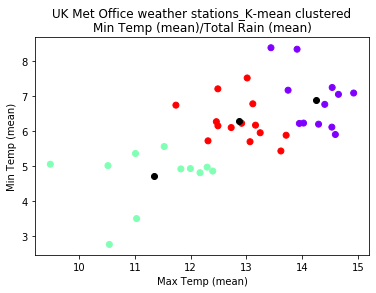

In [567]:
# Plot the data showing the K-means clusters by colour
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
plt.xlabel('Max Temp (mean)')
plt.ylabel('Min Temp (mean)')
plt.title('UK Met Office weather stations_K-mean clustered\nMin Temp (mean)/Total Rain (mean)')
plt.show()

In [568]:
# Scale the data using StandardScaler this time, to later reapply the same transformation to other sets
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [569]:
# Create the K-means model
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

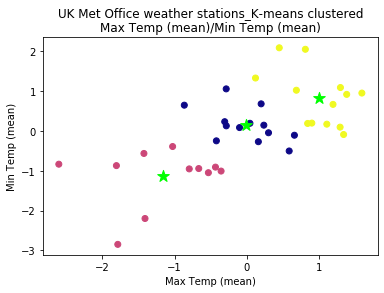

In [570]:
# Plot the newly scaled data, trying a slightly different visualisation style this time
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans.labels_, cmap='plasma')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker='*', s=150, color='lime')
plt.xlabel('Max Temp (mean)')
plt.ylabel('Min Temp (mean)')
plt.title('UK Met Office weather stations_K-means clustered\nMax Temp (mean)/Min Temp (mean)')
plt.savefig('Weather stations_Kmeans clustered_Max Temp (mean) Min Temp (mean).png', dpi=150)
plt.show()

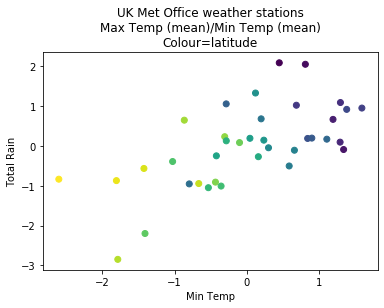

In [572]:
# Plot the scaled data showing the station latitude by colour

# Normalise the latitude classes through encoding
lats = np.ravel(df_mean[['Lat']].to_numpy())
encoder = preprocessing.LabelEncoder()
encoder.fit(lats)
latsEnc = encoder.transform(lats)
y = latsEnc

# Plot the data
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='viridis')
plt.xlabel('Min Temp')
plt.ylabel('Total Rain')
plt.title('UK Met Office weather stations\nMax Temp (mean)/Min Temp (mean)\nColour=latitude')
plt.show()

In [573]:
# Add the new clustering data to the mean DataFrame as a new column
df_mean.loc[:,'Max Temp/Min Temp Clusters'] = kmeans.labels_
df_mean

,Lat,Lon,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean),Max Temp/Min Temp Clusters
Station,,,,,,,,
Aberporth,52.139,-4.570,12.486812,7.202346,2.102344,76.006604,129.522483,0
Armagh,54.352,-6.649,13.063350,5.696512,3.375281,68.736999,115.139845,0
Ballypatrick,55.181,-6.153,11.526201,5.559325,2.835155,86.738298,118.671620,1
Bradford,53.813,-1.772,12.310636,5.721336,3.758714,72.426972,104.317508,0
Braemar,57.006,-3.396,10.543381,2.770387,8.664567,74.946219,105.874397,1
Camborne,50.218,-5.327,13.438048,8.373307,0.750996,89.887849,134.852439,2
Cambridge,52.245,0.102,14.290515,6.196206,3.588076,46.521421,125.474434,2
Cardiff,51.488,-3.187,14.646693,7.045525,2.953307,97.058560,126.025429,2
Chivenor,51.089,-4.147,14.534653,7.240820,2.985329,74.323401,131.214478,2


In [574]:
# Show a list of the stations clustered with a specific label
df_mean[df_mean['Max Temp/Min Temp Clusters'] == 0]

,Lat,Lon,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean),Max Temp/Min Temp Clusters
Station,,,,,,,,
Aberporth,52.139,-4.570,12.486812,7.202346,2.102344,76.006604,129.522483,0
Armagh,54.352,-6.649,13.063350,5.696512,3.375281,68.736999,115.139845,0
Bradford,53.813,-1.772,12.310636,5.721336,3.758714,72.426972,104.317508,0
Dunstaffnage,56.451,-5.439,12.460280,6.267113,2.451428,137.611612,117.605238,0
Lowestoft,52.483,1.727,13.113165,6.775825,2.865353,50.727584,135.280323,0
Paisley,55.846,-4.430,12.725745,6.099458,3.191057,99.515854,106.242818,0
Ringway,53.356,-2.279,13.161526,6.167725,3.565236,66.025160,114.824929,0
Shawbury,52.794,-2.663,13.615774,5.432346,4.892477,55.596421,115.261429,0
Sheffield,53.381,-1.490,12.912358,6.221197,2.918609,66.778364,117.016197,0


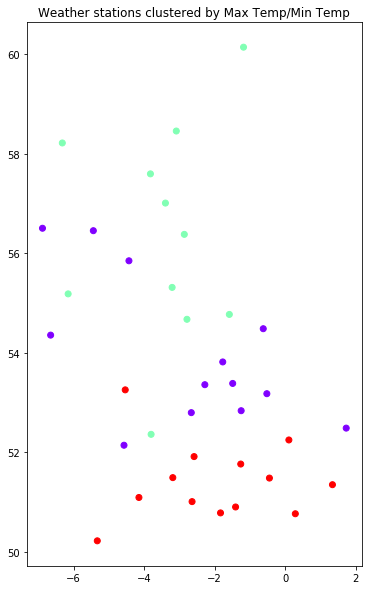

In [575]:
# Plot the stations by Lat and Lon with the K-means Max Temp/Min Temp clusters shown by colour
lat = df_mean['Lat']
lon = df_mean['Lon']
colours = df_mean['Max Temp/Min Temp Clusters']
fig, ax = plt.subplots(figsize=(6, 10))
ax.scatter(lon, lat, c=colours, cmap='rainbow')
plt.title('Weather stations clustered by Max Temp/Min Temp')
plt.savefig('Weather stations_Geo clustered_Max Temp (mean) Min Temp (mean).png', dpi=150)
plt.show()

In [607]:
# A function to quickly run different kinds of clustering analyses 
def makeClusters(df_name, x_axis, y_axis, totalClusters, title):
    
    # Build the K-means model
    X = df_name[[x_axis, y_axis]].to_numpy()
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    kmeans = KMeans(n_clusters=totalClusters)
    kmeans.fit(X_scaled)
    df_name.loc[:,title] = kmeans.labels_
    
    # Print the cluster centre locations
    print('Cluster centres: \n', 
          kmeans.predict([kmeans.cluster_centers_[0]]), kmeans.cluster_centers_[0], '\n', 
          kmeans.predict([kmeans.cluster_centers_[1]]), kmeans.cluster_centers_[1], '\n',
          kmeans.predict([kmeans.cluster_centers_[2]]), kmeans.cluster_centers_[2])
    
    # Plot the results
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans.labels_, cmap='cool')
    plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker='*', s=150, color='lime')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title('UK Met Office weather stations_Colour=K-means cluster\n' + x_axis + '/ ' + y_axis)
    plt.savefig('UK Met Office stations_Colour=K-means cluster_' + x_axis + ' ' + y_axis + '.png', dpi=150)
    plt.show()
    
    # Plot the results, with latitude shown by colour
    lats = np.ravel(df_name[['Lat']].to_numpy())
    encoder = preprocessing.LabelEncoder()
    encoder.fit(lats)
    latsEnc = encoder.transform(lats)
    y = latsEnc
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='viridis')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title('UK Met Office weather stations_Colour=latitude\n' + x_axis + '/ ' + y_axis)
    plt.savefig('UK Met Office stations_Colour=latitude_' + x_axis + ' ' + y_axis + '.png', dpi=150)
    plt.show()

    # Plot the stations by Lat and Lon, showing the clustering results by colour
    lat = df_name['Lat']
    lon = df_name['Lon']
    colours = df_name[title]
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.scatter(lon, lat, c=colours, cmap='rainbow')
    plt.title('UK Met Office weather stations_Colour=K-means cluster\n' + x_axis + '/ ' + y_axis)
    plt.savefig('UK Met Office stations_K-means cluster map_' + x_axis + ' ' + y_axis + '.png', dpi=150)
    plt.show()

### Run the K-means clustering analysis: Looking for stations with 'similar' weather

Cluster centres: 
 [0] [-1.15268318  1.08590426] 
 [1] [0.95229806 0.08638883] 
 [2] [-0.21128745 -0.78447014]


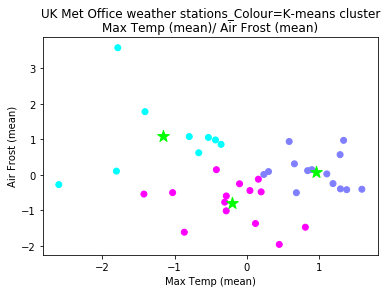

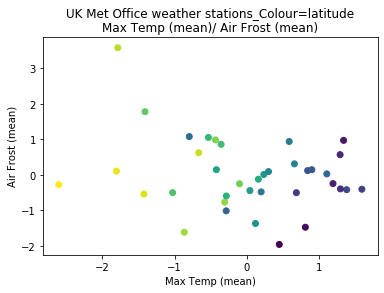

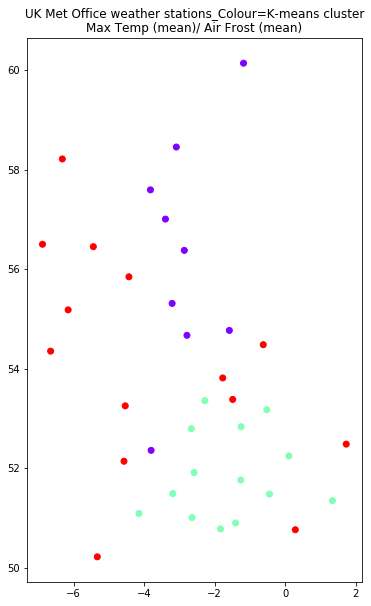

In [608]:
# Run a new clustering analysis
makeClusters(df_mean, 'Max Temp (mean)', 'Air Frost (mean)', 3, 'Max Temp/Air Frost Clusters')

Cluster centres: 
 [0] [-1.08380205  0.42283684] 
 [1] [ 0.5562026  -0.50301806] 
 [2] [-0.8369473   2.61468833]


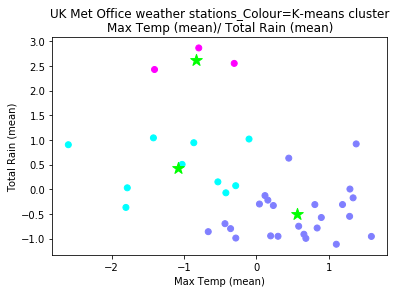

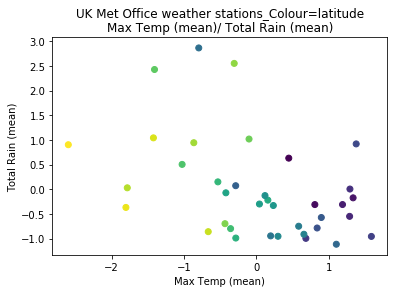

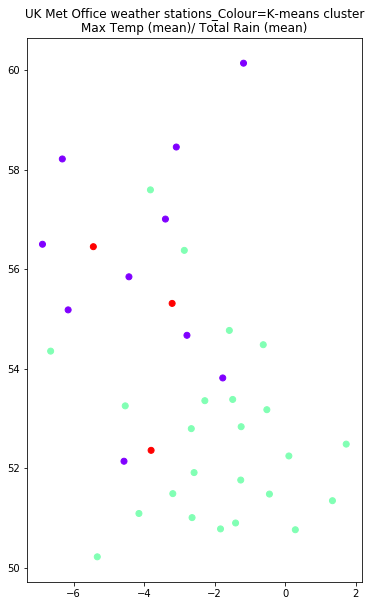

In [609]:
# Run a new clustering analysis
makeClusters(df_mean, 'Max Temp (mean)', 'Total Rain (mean)', 3, 'Max Temp/Total Rain Clusters')

Cluster centres: 
 [0] [-0.22630433 -0.33165424] 
 [1] [0.89509157 0.88525912] 
 [2] [-1.63425072 -1.32873649]


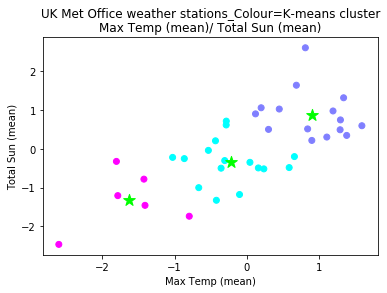

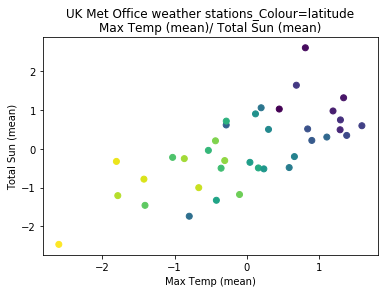

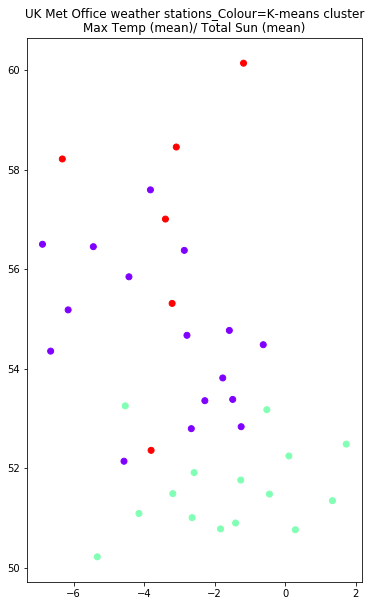

In [611]:
# Run a new clustering analysis
makeClusters(df_mean, 'Max Temp (mean)', 'Total Sun (mean)', 3, 'Max Temp/Total Sun Clusters')

Cluster centres: 
 [0] [-0.37909737  0.30126921] 
 [1] [ 0.92939114 -0.83424609] 
 [2] [-2.52521561  2.67639594]


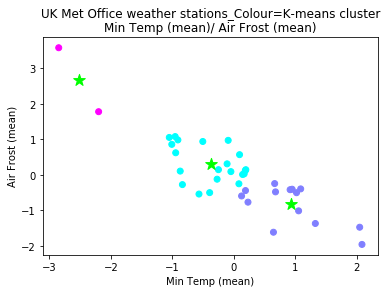

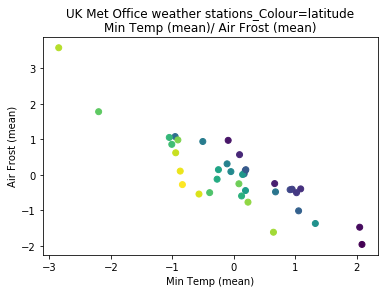

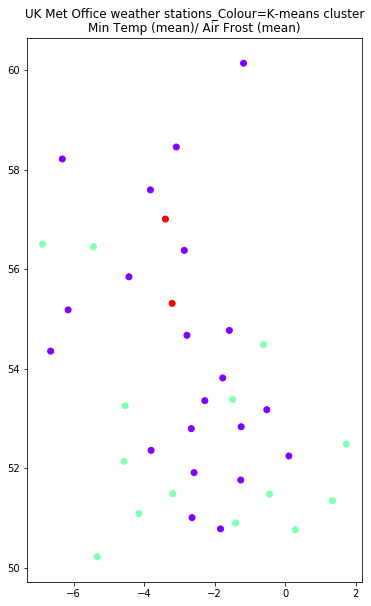

In [612]:
# Run a new clustering analysis
makeClusters(df_mean, 'Min Temp (mean)', 'Air Frost (mean)', 3, 'Min Temp/Air Frost Clusters')

Cluster centres: 
 [0] [-0.93656158  1.41793473] 
 [1] [-0.22614938 -0.59061068] 
 [2] [ 1.17893308 -0.01218749]


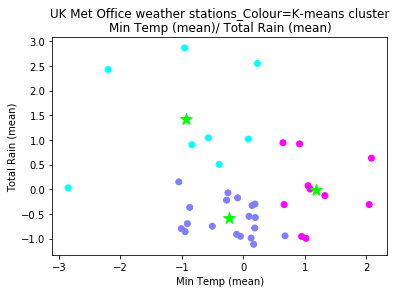

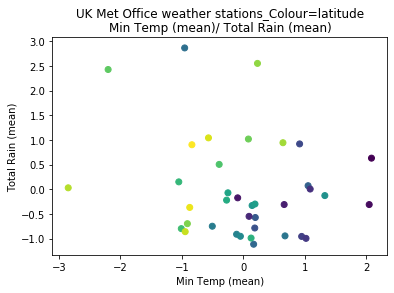

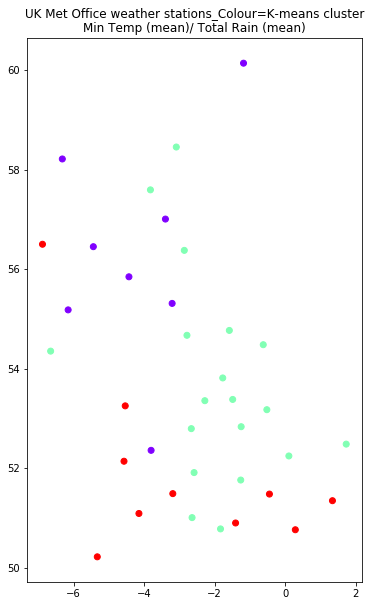

In [613]:
# Run a new clustering analysis
makeClusters(df_mean, 'Min Temp (mean)', 'Total Rain (mean)', 3, 'Min Temp/Total Rain Clusters')

Cluster centres: 
 [0] [-0.25991966 -0.31120842] 
 [1] [0.92625513 1.00710231] 
 [2] [-1.71073085 -1.71704039]


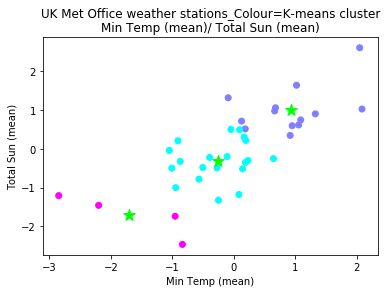

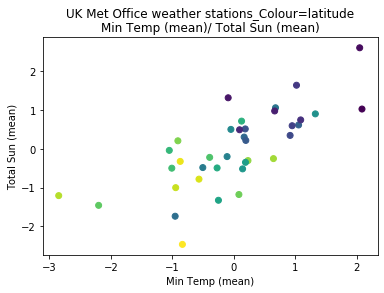

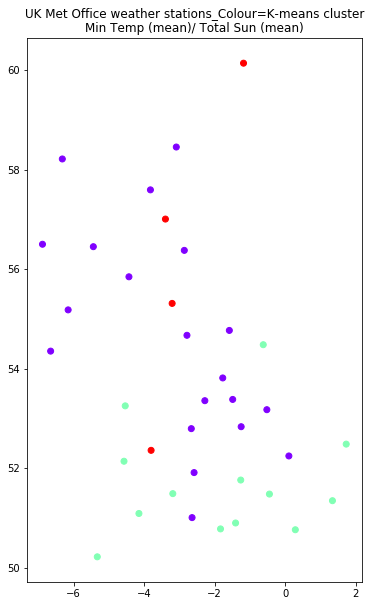

In [614]:
# Run a new clustering analysis
makeClusters(df_mean, 'Min Temp (mean)', 'Total Sun (mean)', 3, 'Min Temp/Total Sun Clusters')

Cluster centres: 
 [0] [ 0.16315342 -0.58585961] 
 [1] [-0.92563608  0.74108101] 
 [2] [2.14315607 1.77429333]


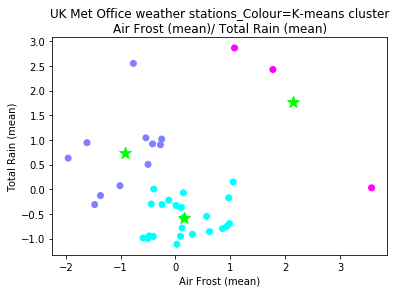

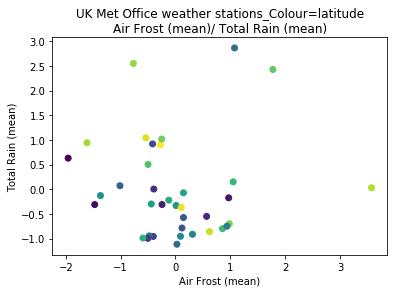

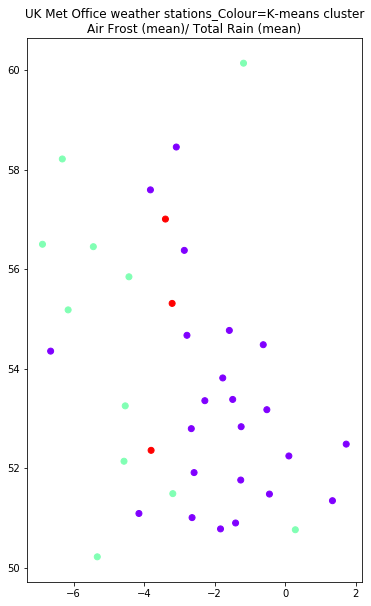

In [615]:
# Run a new clustering analysis
makeClusters(df_mean, 'Air Frost (mean)', 'Total Rain (mean)', 3, 'Air Frost/Total Rain Clusters')

Cluster centres: 
 [0] [-0.40796694  0.85962318] 
 [1] [-0.32877157 -0.69999856] 
 [2] [ 1.3600871  -0.77670143]


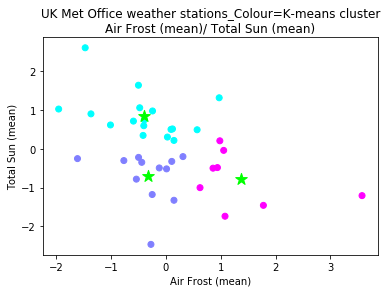

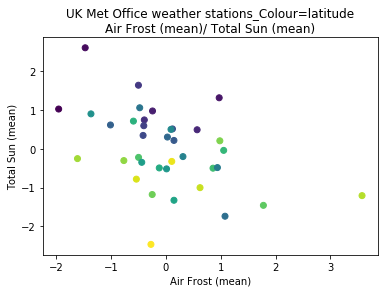

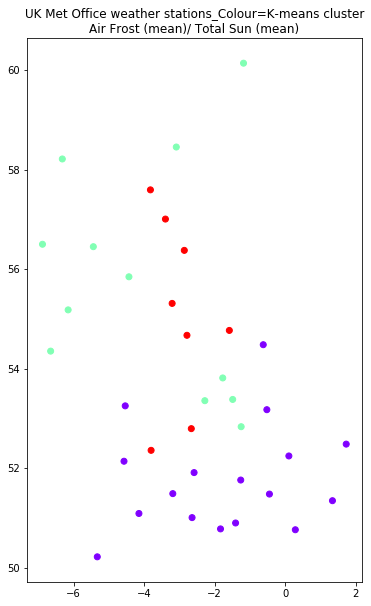

In [616]:
# Run a new clustering analysis
makeClusters(df_mean, 'Air Frost (mean)', 'Total Sun (mean)', 3, 'Air Frost/Total Sun Clusters')

Cluster centres: 
 [0] [-0.51514074  0.8514451 ] 
 [1] [ 1.8014403 -1.3204082] 
 [2] [-0.1465178  -0.46800839]


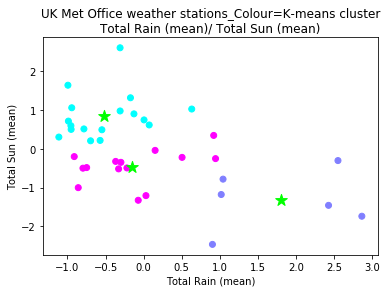

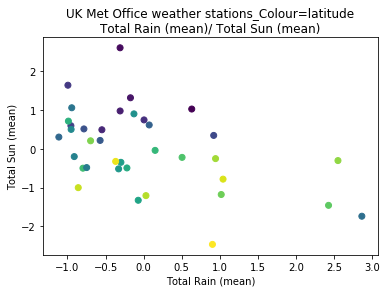

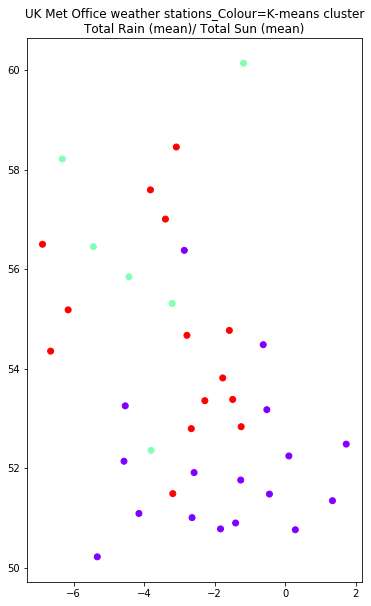

In [617]:
# Run a new clustering analysis
makeClusters(df_mean, 'Total Rain (mean)', 'Total Sun (mean)', 3, 'Total Rain/Total Sun Clusters')

### Prepare a data subset for K-nearest neighbours classification

In [618]:
# Determining the latitude of Northern Third, Central Third and Southern Third of the UK
# Most northerly point = latitude 60.9, Most southerly point = latitude 49.9

latInt = (60.9 - 49.9)/3
nStart = 60.9
nEnd = 60.9-latInt
cStart = nEnd
cEnd = cStart-latInt
sStart = cEnd
sEnd = 49.9

print('Interval between UK latitude thirds = ' + str(latInt) + '\n',
      'Northern Third start = ' + str(nStart) + '\n',
      'Northern Third end = ' + str(nEnd) + '\n',
      'Central Third start = ' + str(cStart) + '\n',
      'Central Third end = ' + str(cEnd) + '\n',
      'Southern Third start = ' + str(sStart) + '\n',
      'Southern Third End = ' + str(sEnd) + '\n')

Interval between UK latitude thirds = 3.6666666666666665
 Northern Third start = 60.9
 Northern Third end = 57.233333333333334
 Central Third start = 57.233333333333334
 Central Third end = 53.56666666666667
 Southern Third start = 53.56666666666667
 Southern Third End = 49.9



In [619]:
# Create a new version of the DataFrame to work with during the classification analysis
df_edited_2 = df_weather.copy()
df_KNN = df_edited_2.groupby('Station')[['Max Temp', 'Min Temp', 'Air Frost', 
                                         'Total Rain', 'Total Sun']].mean()
df_KNN = df_KNN.rename(columns={'Max Temp': 'Max Temp (mean)', 'Min Temp': 'Min Temp (mean)', 
                        'Air Frost': 'Air Frost (mean)', 'Total Rain': 'Total Rain (mean)', 
                        'Total Sun': 'Total Sun (mean)'})
df_KNN.insert(0, 'Lon', df_latLon['Lon'])
df_KNN.insert(0, 'Lat', df_latLon['Lat'])
df_KNN

,Lat,Lon,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean)
Station,,,,,,,
Aberporth,52.139,-4.570,12.486812,7.202346,2.102344,76.006604,129.522483
Armagh,54.352,-6.649,13.063350,5.696512,3.375281,68.736999,115.139845
Ballypatrick,55.181,-6.153,11.526201,5.559325,2.835155,86.738298,118.671620
Bradford,53.813,-1.772,12.310636,5.721336,3.758714,72.426972,104.317508
Braemar,57.006,-3.396,10.543381,2.770387,8.664567,74.946219,105.874397
Camborne,50.218,-5.327,13.438048,8.373307,0.750996,89.887849,134.852439
Cambridge,52.245,0.102,14.290515,6.196206,3.588076,46.521421,125.474434
Cardiff,51.488,-3.187,14.646693,7.045525,2.953307,97.058560,126.025429
Chivenor,51.089,-4.147,14.534653,7.240820,2.985329,74.323401,131.214478


In [622]:
# Assign a classification to each station according to its latitude
classDict = df_KNN['Lat'].to_dict()

for key, value in classDict.items():
    if value > 57.233333333333334:
        classDict[key] = 0 # Northern Third
    elif value > 53.56666666666667:
        classDict[key] = 1 # Central Third
    else:
        classDict[key] = 2 # Southern Third
    
# Add the classifications to the mean DataFrame as a new column
df_class = pd.DataFrame.from_dict(classDict, orient='index')
df_KNN.loc[:,'Class'] = df_class[0]
df_KNN

,Lat,Lon,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean),Class
Station,,,,,,,,
Aberporth,52.139,-4.570,12.486812,7.202346,2.102344,76.006604,129.522483,2
Armagh,54.352,-6.649,13.063350,5.696512,3.375281,68.736999,115.139845,1
Ballypatrick,55.181,-6.153,11.526201,5.559325,2.835155,86.738298,118.671620,1
Bradford,53.813,-1.772,12.310636,5.721336,3.758714,72.426972,104.317508,1
Braemar,57.006,-3.396,10.543381,2.770387,8.664567,74.946219,105.874397,1
Camborne,50.218,-5.327,13.438048,8.373307,0.750996,89.887849,134.852439,2
Cambridge,52.245,0.102,14.290515,6.196206,3.588076,46.521421,125.474434,2
Cardiff,51.488,-3.187,14.646693,7.045525,2.953307,97.058560,126.025429,2
Chivenor,51.089,-4.147,14.534653,7.240820,2.985329,74.323401,131.214478,2


In [623]:
# Create a new DataFrame containing weather and classification data only for the last 5 stations
# This will be used to try and predict the latitude classifications
df_KNN_last5 = df_KNN[['Max Temp (mean)', 'Min Temp (mean)', 'Air Frost (mean)', 'Total Rain (mean)', 'Total Sun (mean)', 'Class']].tail(5)
df_KNN_last5

,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean),Class
Station,,,,,,
Valley,13.012000,7.511628,1.593488,71.029551,133.236854,2
Waddington,13.245238,5.951361,3.681071,50.528118,128.042063,2
Whitby,12.488472,6.148779,2.701118,49.637920,130.810737,1
Wickairport,10.518781,5.015294,3.701370,65.062050,117.325860,0
Yeovilton,14.528806,6.111493,4.362687,60.567015,127.917768,2


In [624]:
# Create a new DataFrame containing weather and classification data only, for all except the last 5 stations
# This will be used to train the latitude classifications model
df_KNN_minus5 = df_KNN[['Max Temp (mean)', 'Min Temp (mean)', 'Air Frost (mean)', 'Total Rain (mean)', 'Total Sun (mean)', 'Class']].drop(df_mean.tail(5).index)
df_KNN_minus5

,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean),Class
Station,,,,,,
Aberporth,12.486812,7.202346,2.102344,76.006604,129.522483,2
Armagh,13.063350,5.696512,3.375281,68.736999,115.139845,1
Ballypatrick,11.526201,5.559325,2.835155,86.738298,118.671620,1
Bradford,12.310636,5.721336,3.758714,72.426972,104.317508,1
Braemar,10.543381,2.770387,8.664567,74.946219,105.874397,1
Camborne,13.438048,8.373307,0.750996,89.887849,134.852439,2
Cambridge,14.290515,6.196206,3.588076,46.521421,125.474434,2
Cardiff,14.646693,7.045525,2.953307,97.058560,126.025429,2
Chivenor,14.534653,7.240820,2.985329,74.323401,131.214478,2


### Run the K-nearest neighbours classification: Trying to predict UK latitude location using weather data only

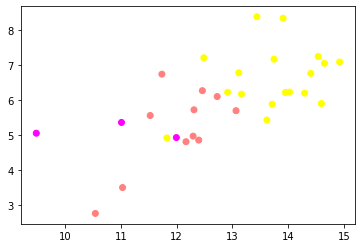

In [625]:
# Define the X and y values for the classifier and visualise them
X = df_KNN_minus5.to_numpy()
y = df_KNN_minus5['Class'].to_numpy()
plt.scatter(X[:,0], X[:,1], c=y, cmap='spring')

In [626]:
# Create a classifier with default values
classifier = KNeighborsClassifier()
classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [627]:
# Split the data into training and test sets, with a test size of 40% of the total data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

In [628]:
# Check the sizes of the sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19, 6)
(13, 6)
(19,)
(13,)


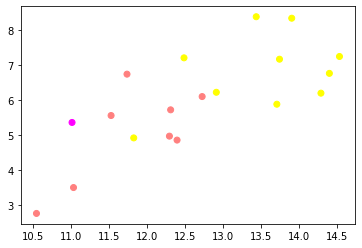

In [629]:
# Plot the training set values
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='spring')

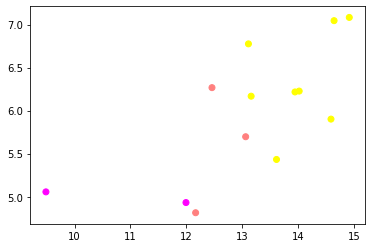

In [630]:
# Plot the test set values
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='spring')

In [631]:
# Train the classifier, the output showing the value of k as chosen by the model
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [632]:
# Run the test set through the trained model
pred = classifier.predict(X_test)
pred

array([2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2])

Accuracy score:  0.6153846153846154


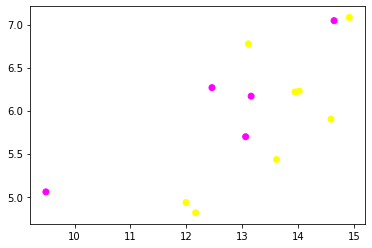

In [633]:
# Plot the test set values with the predicted classifications shown by colour
plt.scatter(X_test[:,0], X_test[:,1], c=pred, cmap='spring')
print('Accuracy score: ', accuracy_score(y_test, pred))

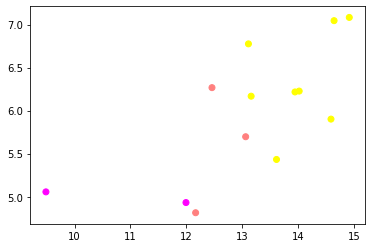

In [634]:
# Plot the test set values with the actual classifications shown by colour
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='spring')

In [635]:
# Run the K-nearest neighbours model on the last 5 stations from the data set
X_last5 = df_KNN_last5.to_numpy()
y_last5 = df_KNN_last5['Class'].to_numpy()
pred_2 = classifier.predict(X_last5)
pred_2

array([2, 2, 2, 1, 2])

Accuracy score:  0.6


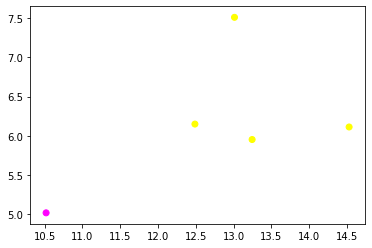

In [636]:
# Plot the test set values with the predicted classifications shown by colour
plt.scatter(X_last5[:,0], X_last5[:,1], c=pred_2, cmap='spring')
print('Accuracy score: ', accuracy_score(y_last5, pred_2))

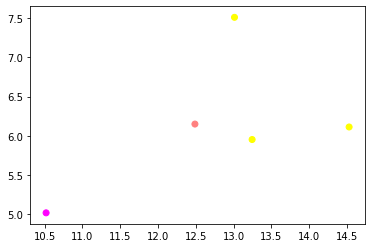

In [637]:
# Plot the test set values with the actual classifications shown by colour
plt.scatter(X_last5[:,0], X_last5[:,1], c=y_last5, cmap='spring')

### Run the K-nearest neighbours classification again with scaled data

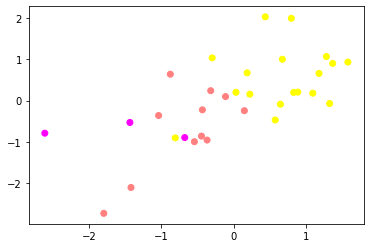

In [641]:
# Define the X and y values for the classifier and visualise them
X = df_KNN_minus5.to_numpy()
y = df_KNN_minus5['Class'].to_numpy()
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='spring')

In [642]:
# Create a classifier with default values
classifier = KNeighborsClassifier()
classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [643]:
# Split the data into training and test sets, with a test size of 40% of the total data
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.4)

In [644]:
# Check the sizes of the sets
print(X_scaled_train.shape)
print(X_scaled_test.shape)
print(y_train.shape)
print(y_test.shape)

(19, 6)
(13, 6)
(19,)
(13,)


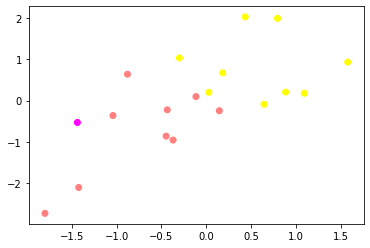

In [645]:
# Plot the training set values
plt.scatter(X_scaled_train[:,0], X_scaled_train[:,1], c=y_train, cmap='spring')

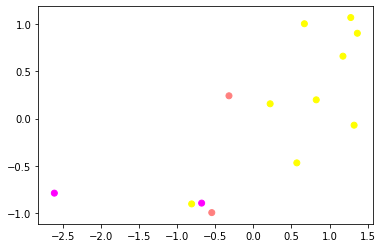

In [646]:
# Plot the test set values
plt.scatter(X_scaled_test[:,0], X_scaled_test[:,1], c=y_test, cmap='spring')

In [647]:
# Train the classifier, the output showing the value of k as chosen by the model
classifier.fit(X_scaled_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [648]:
# Run the test set through the trained model
pred = classifier.predict(X_scaled_test)
pred

array([2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1])

Accuracy score:  0.7692307692307693


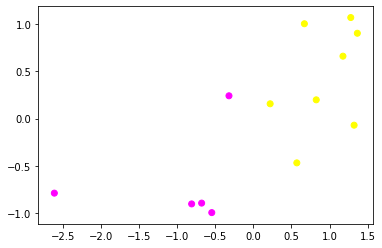

In [649]:
# Plot the test set values with the predicted classifications shown by colour
plt.scatter(X_scaled_test[:,0], X_scaled_test[:,1], c=pred, cmap='spring')
print('Accuracy score: ', accuracy_score(y_test, pred))

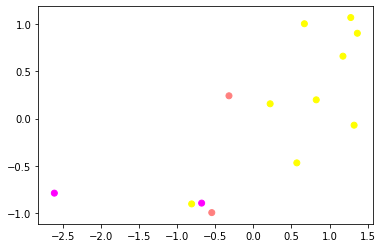

In [650]:
# Plot the test set values with the actual classifications shown by colour
plt.scatter(X_scaled_test[:,0], X_scaled_test[:,1], c=y_test, cmap='spring')

### Prepare a happiness / weather data set for analysis by linear regression

In [1416]:
# Create a DataFrame using the ONS Happiness data Excel sheet
df_happy = pd.read_excel('/Users/NAMEREMOVED/Documents/Data Science/_Assessment/geographicbreakdownreferencetable'
              '_tcm77-417203.xls', sheet_name='Happiness')

# Drop all columns after the Average (mean) Rating column
df_happy = df_happy.loc[:, :'Unnamed: 8']
df_happy

,"Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Per cent in each category on 11 point scale3:,NaN,NaN,NaN,Average (mean) rating
2,NaN,NaN,NaN,NaN,Low,Medium,High,Very High,NaN
3,NaN,NaN,NaN,NaN,0-4,5-6,7-8,9-10,NaN
4,Area Codes,Area names,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,"Source: April 2014 to March 2015, Annual Popul...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1417]:
# Check where the actual data starts
df_happy[5:]

,"Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
5,K02000001,UNITED KINGDOM,NaN,NaN,8.93,16.68,40.28,34.11,7.46
6,E92000001,ENGLAND,NaN,NaN,8.95,16.73,40.47,33.85,7.45
7,E12000001,NORTH EAST,NaN,NaN,10.77,17.05,39.06,33.13,7.34
8,E06000047,NaN,County Durham UA,NaN,10.84,17.04,37.76,34.36,7.37
9,E06000005,NaN,Darlington UA,NaN,9.76,15.43,38.68,36.13,7.46
...,...,...,...,...,...,...,...,...,...
457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,"Source: April 2014 to March 2015, Annual Popul...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1418]:
# Check where the actual data ends
df_happy.tail(15)

,"Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
447,"1 Question: Overall, how happy did you feel ye...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,2 All estimates weighted.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,3 Estimates may not add to 100% due to rounding.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,4 Estimates for 2014/15 have been weighted usi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,5 Northern Ireland reformed its local governme...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,# Data unavailable.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,* There is no single geography code for these ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,x Data has been suppressed as the CV> 20% or u...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,The colour coding indicates the variability ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1419]:
# Isolate the rows of actual data only
df_happy = df_happy.loc[5:446]
df_happy

,"Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
5,K02000001,UNITED KINGDOM,NaN,NaN,8.93,16.68,40.28,34.11,7.46
6,E92000001,ENGLAND,NaN,NaN,8.95,16.73,40.47,33.85,7.45
7,E12000001,NORTH EAST,NaN,NaN,10.77,17.05,39.06,33.13,7.34
8,E06000047,NaN,County Durham UA,NaN,10.84,17.04,37.76,34.36,7.37
9,E06000005,NaN,Darlington UA,NaN,9.76,15.43,38.68,36.13,7.46
...,...,...,...,...,...,...,...,...,...
442,N09000008,NaN,NaN,Mid and East Antrim,x,x,x,x,8.03
443,N09000009,NaN,NaN,Mid Ulster,x,x,x,x,7.91
444,N09000010,NaN,NaN,"Newry, Mourne and Down",x,x,x,x,7.84
445,N09000011,NaN,NaN,North Down and Ards,x,x,x,x,7.32


In [1420]:
# Rename the columns, visually cross referencing between the DataFrame and the Excel sheet to get the correct names
df_happy = df_happy.rename(columns={'Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4'
                                    : 'Area Code',
                                    'Unnamed: 1': 'Region', 
                                    'Unnamed: 2': 'Area Name 2',
                                    'Unnamed: 3': 'Area Name 3', 
                                    'Unnamed: 4': 'Low 0-4',
                                    'Unnamed: 5': 'Medium 5-6', 
                                    'Unnamed: 6': 'High 7-8',
                                    'Unnamed: 7': 'Very High 9-10', 
                                    'Unnamed: 8': 'Mean Rating',})
df_happy

,Area Code,Region,Area Name 2,Area Name 3,Low 0-4,Medium 5-6,High 7-8,Very High 9-10,Mean Rating
5,K02000001,UNITED KINGDOM,NaN,NaN,8.93,16.68,40.28,34.11,7.46
6,E92000001,ENGLAND,NaN,NaN,8.95,16.73,40.47,33.85,7.45
7,E12000001,NORTH EAST,NaN,NaN,10.77,17.05,39.06,33.13,7.34
8,E06000047,NaN,County Durham UA,NaN,10.84,17.04,37.76,34.36,7.37
9,E06000005,NaN,Darlington UA,NaN,9.76,15.43,38.68,36.13,7.46
...,...,...,...,...,...,...,...,...,...
442,N09000008,NaN,NaN,Mid and East Antrim,x,x,x,x,8.03
443,N09000009,NaN,NaN,Mid Ulster,x,x,x,x,7.91
444,N09000010,NaN,NaN,"Newry, Mourne and Down",x,x,x,x,7.84
445,N09000011,NaN,NaN,North Down and Ards,x,x,x,x,7.32


In [1423]:
# Create a DataFrame using the Regions txt file
df_txt = pd.read_table('regions.txt', sep=',', header=None, names=['Area Code', 'Region', 'Lat', 'Lon'])
df_txt

,Area Code,Region,Lat,Lon
0,E12000001,NORTH EAST,55.0,-1.9
1,E12000002,NORTH WEST,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
3,E12000004,EAST MIDLANDS,53.0,-0.8
4,E12000005,WEST MIDLANDS,52.5,-2.3
5,E12000006,EAST,52.2,0.4
6,E12000007,LONDON,51.5,-0.1
7,E12000008,SOUTH EAST,51.3,-0.5
8,E12000009,SOUTH WEST,51.0,-3.2
9,W92000004,WALES,51.5,-3.2


In [1424]:
# Check the Dtypes in the new DataFrame
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area Code  12 non-null     object 
 1   Region     12 non-null     object 
 2   Lat        12 non-null     float64
 3   Lon        12 non-null     float64
dtypes: float64(2), object(2)
memory usage: 512.0+ bytes


In [1559]:
# Create the regions DataFrame
# Isolate the region entries only using the Regions txt file and assign to a new variable
codeList = []
for i in df_txt['Area Code']:
    codeList.append(i)
df_regions = df_happy.loc[df_happy['Area Code'].isin(codeList)]
df_regions = df_regions.dropna('columns')

# Change all Dtypes to numeric, ignoring strings
for i in range(0, len(df_regions.columns)):
    df_regions.iloc[:,i] = pd.to_numeric(df_regions.iloc[:,i], errors='ignore')
    
# Insert Lat and Lon values as new columns using the Regions txt file
lat = df_txt['Lat'].to_numpy()
lon = df_txt['Lon'].to_numpy()
df_regions.insert(1, 'Lon', lon)
df_regions.insert(1, 'Lat', lat)
df_regions

,Area Code,Lat,Lon,Region,Low 0-4,Medium 5-6,High 7-8,Very High 9-10,Mean Rating
7,E12000001,55.0,-1.9,NORTH EAST,10.77,17.05,39.06,33.13,7.34
21,E12000002,54.0,-2.6,NORTH WEST,10.17,16.82,39.10,33.91,7.39
65,E12000003,53.6,-1.2,YORKSHIRE AND THE HUMBER,10.21,16.60,38.56,34.63,7.41
90,E12000004,53.0,-0.8,EAST MIDLANDS,8.66,16.74,38.62,35.99,7.51
136,E12000005,52.5,-2.3,WEST MIDLANDS,8.61,17.59,41.72,32.08,7.43
171,E12000006,52.2,0.4,EAST,8.53,15.69,41.69,34.09,7.51
224,E12000007,51.5,-0.1,LONDON,8.32,18.30,42.20,31.18,7.38
260,E12000008,51.3,-0.5,SOUTH EAST,7.97,15.83,40.88,35.32,7.54
335,E12000009,51.0,-3.2,SOUTH WEST,8.79,15.92,40.44,34.84,7.50
377,W92000004,51.5,-3.2,WALES,9.56,16.54,39.45,34.45,7.44


In [1560]:
df_regions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 7 to 434
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       12 non-null     object 
 1   Lat             12 non-null     float64
 2   Lon             12 non-null     float64
 3   Region          12 non-null     object 
 4   Low 0-4         12 non-null     float64
 5   Medium 5-6      12 non-null     float64
 6   High 7-8        12 non-null     float64
 7   Very High 9-10  12 non-null     float64
 8   Mean Rating     12 non-null     float64
dtypes: float64(7), object(2)
memory usage: 960.0+ bytes


In [1561]:
# Export DataFrame to csv for storage
df_regions.to_csv('region happiness data.csv')

In [1562]:
# Create a new DataFrame for linear regression analysis, sorted by Lat values descending
df_regr = df_mean.copy()
df_regr = df_regr.loc[:, :'Total Sun (mean)']
df_regr = df_regr.sort_values(by='Lat', ascending=False)
df_regr[['Lat', 'Lon']]

,Lat,Lon
Station,,
Lerwick,60.139,-1.183
Wickairport,58.454,-3.088
Stornoway,58.214,-6.318
Nairn,57.593,-3.821
Braemar,57.006,-3.396
Tiree,56.500,-6.880
Dunstaffnage,56.451,-5.439
Leuchars,56.377,-2.861
Paisley,55.846,-4.430


In [1563]:
# Assign regions to weather stations using Lat and Lon data
# Looking at a Lat Lon map of the UK I have chosen these grid boundaries

LL = df_regr[['Lat', 'Lon']].to_numpy()
regionList = []

for lat, lon in LL:
    
    if lat >55.3 and lon >-8:
        region = 'Scotland'
        regionList.append(region)
    
    elif lat <=55.3 and lat >54 and lon <=-6:
        region = 'Northern Ireland'
        regionList.append(region)

    elif lat <=55.3 and lat >54.5 and lon >-2:
        region = 'North East'
        regionList.append(region)

    elif lat <=55.3 and lat >53.3 and lon <=-2 and lon >-3.1:
        region = 'North West'
        regionList.append(region)
        
    elif lat <=54.5 and lat >53.3 and lon >-2:
        region = 'Yorkshire and the Humber'
        regionList.append(region)
    
    elif lat <=53.3 and lat >52 and lon >-1.5:
        region = 'East Midlands'
        regionList.append(region)
        
    elif lat <= 53 and lat > 52 and lon >-3:
        region = 'West Midlands'
        regionList.append(region)
        
    elif lat <=53.253 and lat >51.48 and lon >-5.5 and lon <=-3.1:
        region = 'Wales'
        regionList.append(region)
        
    elif lat <= 53 and lat >51.8 and lon >-1.5:
        region = 'East'
        regionList.append(region)
    
    elif lat <=51.6 and lat >51.4 and lon >-0.5 and lon <=0:
        region = 'London'
        regionList.append(region)
    
    elif lat <=52 and lat >50.5 and lon >-1.5:
        region = 'South East'
        regionList.append(region)
        
    elif lat <=52 and lat >50 and lon >-5.8 and lon <=-1.5:
        region = 'South West'
        regionList.append(region)    

In [1564]:
# Add the region data as a column on the new DataFrame for linear regression analysis
df_regr.insert(2, 'Region', regionList)
df_regr

,Lat,Lon,Region,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean)
Station,,,,,,,,
Lerwick,60.139,-1.183,Scotland,9.486233,5.055628,3.158140,96.648930,89.553209
Wickairport,58.454,-3.088,Scotland,10.518781,5.015294,3.701370,65.062050,117.325860
Stornoway,58.214,-6.318,Scotland,11.011897,5.361774,2.777878,100.107672,111.388985
Nairn,57.593,-3.821,Scotland,11.994617,4.931531,4.438620,52.853106,108.540248
Braemar,57.006,-3.396,Scotland,10.543381,2.770387,8.664567,74.946219,105.874397
Tiree,56.500,-6.880,Scotland,11.735773,6.737750,1.242067,97.660852,118.261670
Dunstaffnage,56.451,-5.439,Scotland,12.460280,6.267113,2.451428,137.611612,117.605238
Leuchars,56.377,-2.861,Scotland,12.294619,4.972047,4.955381,56.878740,124.223097
Paisley,55.846,-4.430,Scotland,12.725745,6.099458,3.191057,99.515854,106.242818


In [1565]:
# Export DataFrame to csv for storage
df_regr.to_csv('weather region data.csv')

In [1598]:
# Sort region DataFrame by 
df_regions = df_regions.sort_values('Region')
df_regions = df_regions[df_regions.Region != 'EAST'].reset_index(drop=True)
df_regions

,Area Code,Lat,Lon,Region,Low 0-4,Medium 5-6,High 7-8,Very High 9-10,Mean Rating
0,E12000004,53.0,-0.8,EAST MIDLANDS,8.66,16.74,38.62,35.99,7.51
1,E12000007,51.5,-0.1,LONDON,8.32,18.30,42.20,31.18,7.38
2,E12000001,55.0,-1.9,NORTH EAST,10.77,17.05,39.06,33.13,7.34
3,E12000002,54.0,-2.6,NORTH WEST,10.17,16.82,39.10,33.91,7.39
4,N92000002,54.6,5.9,NORTHERN IRELAND5,6.76,14.66,37.57,41.00,7.75
5,S92000003,56.0,-3.2,SCOTLAND,9.16,16.90,39.75,34.19,7.45
6,E12000008,51.3,-0.5,SOUTH EAST,7.97,15.83,40.88,35.32,7.54
7,E12000009,51.0,-3.2,SOUTH WEST,8.79,15.92,40.44,34.84,7.50
8,W92000004,51.5,-3.2,WALES,9.56,16.54,39.45,34.45,7.44
9,E12000005,52.5,-2.3,WEST MIDLANDS,8.61,17.59,41.72,32.08,7.43


In [1599]:
low = df_regions['Low 0-4'].to_list()
med = df_regions['Medium 5-6'].to_list()
high = df_regions['High 7-8'].to_list()
vhigh = df_regions['Very High 9-10'].to_list()
meanR = df_regions['Mean Rating'].to_list()

In [1600]:
df_regr_sort = df_regr.copy()
df_regr_sort = df_regr_sort.groupby('Region')[['Max Temp (mean)', 'Min Temp (mean)', 'Air Frost (mean)', 
                                         'Total Rain (mean)', 'Total Sun (mean)']].mean()
df_regr_sort.insert(5, 'Mean Rating', meanR, True) 
df_regr_sort.insert(5, 'Very High 9-10', vhigh, True) 
df_regr_sort.insert(5, 'High 7-8', high, True) 
df_regr_sort.insert(5, 'Medium 5-6', med, True) 
df_regr_sort.insert(5, 'Low 0-4', low, True) 
df_regr_sort

,Max Temp (mean),Min Temp (mean),Air Frost (mean),Total Rain (mean),Total Sun (mean),Low 0-4,Medium 5-6,High 7-8,Very High 9-10,Mean Rating
Region,,,,,,,,,,
East Midlands,13.589635,6.201139,3.531931,49.830767,126.933613,8.66,16.74,38.62,35.99,7.51
London,14.919080,7.082989,2.971669,50.456092,129.270022,8.32,18.30,42.20,31.18,7.38
North East,12.395154,4.859615,4.777202,54.383037,115.057744,10.77,17.05,39.06,33.13,7.34
North West,12.664435,5.490502,4.310396,71.982233,117.920828,10.17,16.82,39.10,33.91,7.39
Northern Ireland,12.294776,5.627919,3.105218,77.737648,116.905733,6.76,14.66,37.57,41.00,7.75
Scotland,11.380271,5.071868,4.067194,91.582172,110.163420,9.16,16.90,39.75,34.19,7.45
South East,13.999661,7.117952,2.798613,59.301132,140.146936,7.97,15.83,40.88,35.32,7.54
South West,14.222930,6.770800,3.359094,70.932460,131.391137,8.79,15.92,40.44,34.84,7.50
Wales,12.992494,6.670298,2.934894,97.375287,121.940301,9.56,16.54,39.45,34.45,7.44


In [1634]:
df_regr_sort.iloc[:,5]

Region
East Midlands                8.66
London                       8.32
North East                  10.77
North West                  10.17
Northern Ireland             6.76
Scotland                     9.16
South East                   7.97
South West                   8.79
Wales                        9.56
West Midlands                8.61
Yorkshire and the Humber    10.21
Name: Low 0-4, dtype: float64

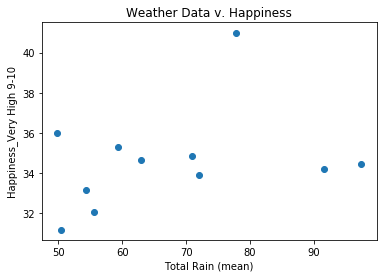

In [1630]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,3]
y = df_regr_sort.iloc[:,8]
plt.scatter(X, y)
plt.xlabel('Total Rain (mean)')
plt.ylabel('Happiness_Very High 9-10')
plt.title('Weather Data v. Happiness')
plt.show()

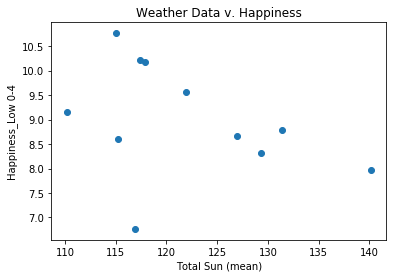

In [1635]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,4]
y = df_regr_sort.iloc[:,5]
plt.scatter(X, y)
plt.xlabel('Total Sun (mean)')
plt.ylabel('Happiness_Low 0-4')
plt.title('Weather Data v. Happiness')
plt.show()

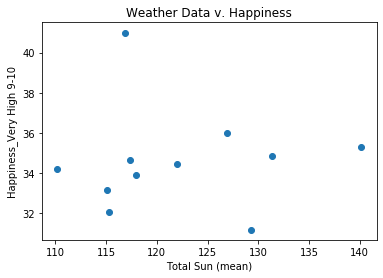

In [1640]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,4]
y = df_regr_sort.iloc[:,8]
plt.scatter(X, y)
plt.xlabel('Total Sun (mean)')
plt.ylabel('Happiness_Very High 9-10')
plt.title('Weather Data v. Happiness')
plt.show()

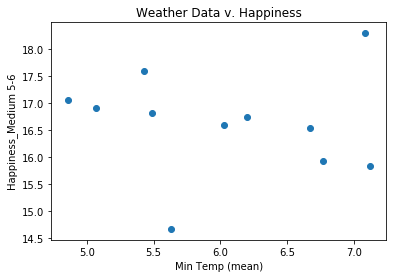

In [1644]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,1]
y = df_regr_sort.iloc[:,6]
plt.scatter(X, y)
plt.xlabel('Min Temp (mean)')
plt.ylabel('Happiness_Medium 5-6')
plt.title('Weather Data v. Happiness')
plt.show()

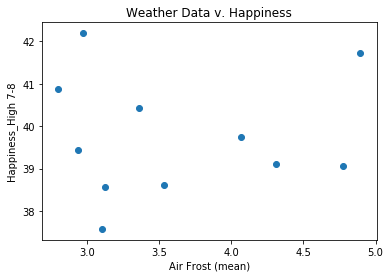

In [1645]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,2]
y = df_regr_sort.iloc[:,7]
plt.scatter(X, y)
plt.xlabel('Air Frost (mean)')
plt.ylabel('Happiness_High 7-8')
plt.title('Weather Data v. Happiness')
plt.show()

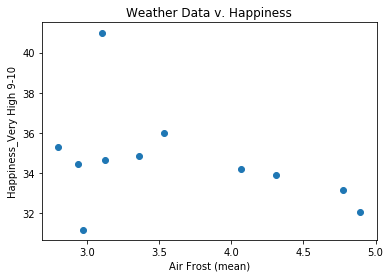

In [1646]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,2]
y = df_regr_sort.iloc[:,8]
plt.scatter(X, y)
plt.xlabel('Air Frost (mean)')
plt.ylabel('Happiness_Very High 9-10')
plt.title('Weather Data v. Happiness')
plt.show()

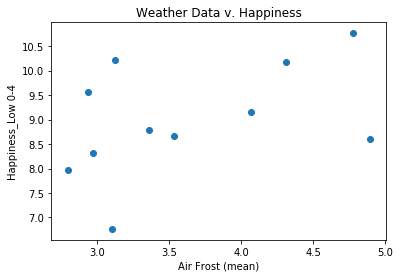

In [1647]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,2]
y = df_regr_sort.iloc[:,5]
plt.scatter(X, y)
plt.xlabel('Air Frost (mean)')
plt.ylabel('Happiness_Low 0-4')
plt.title('Weather Data v. Happiness')
plt.show()

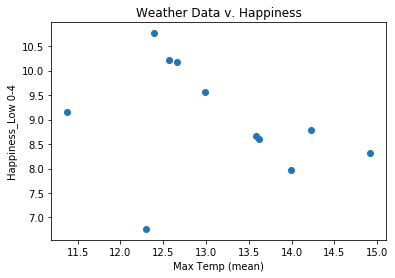

In [1643]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,0]
y = df_regr_sort.iloc[:,5]
plt.scatter(X, y)
plt.xlabel('Max Temp (mean)')
plt.ylabel('Happiness_Low 0-4')
plt.title('Weather Data v. Happiness')
plt.show()

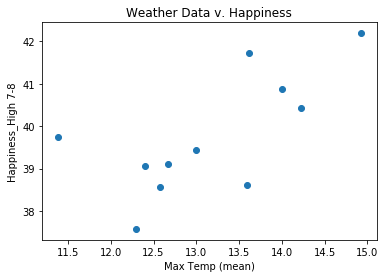

In [1649]:
# Plot subset of weather data against subset of happiness data. 
X = df_regr_sort.iloc[:,0]
y = df_regr_sort.iloc[:,7]
plt.scatter(X, y)
plt.xlabel('Max Temp (mean)')
plt.ylabel('Happiness_High 7-8')
plt.title('Weather Data v. Happiness')
plt.show()

In [1653]:
# Try to create a model which could potentially predict happiness from weather data
reg=LinearRegression().fit(df_regr_sort.iloc[:,0:1],df_regr_sort.iloc[:,7:8])

Text(0.5, 1.0, 'Weather Data v. Happiness')

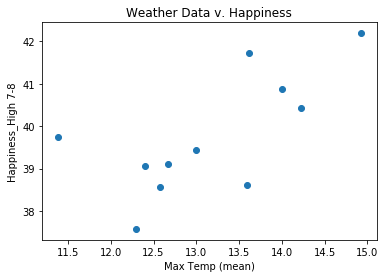

In [1663]:
# Original data with no regression line shown
plt.scatter(df_regr_sort.iloc[:,0:1],df_regr_sort.iloc[:,7:8])
plt.xlabel('Max Temp (mean)')
plt.ylabel('Happiness_High 7-8')
plt.title('Weather Data v. Happiness')

In [1656]:
# Get the coefficient for the linear regression (the "slope") that we obtained from doing the fit
reg.coef_

array([[0.94739916]])

In [1657]:
# Get the intercept on the y-axis
reg.intercept_

array([27.3012485])

In [1659]:
# Manually get a predicted value of y for each x  point using the normal formula for a straight line
ypred=df_regr_sort.iloc[:,0:1]*reg.coef_+reg.intercept_
ypred

,Max Temp (mean)
Region,
East Midlands,40.176057
London,41.435573
North East,39.044407
North West,39.299523
Northern Ireland,38.949309
Scotland,38.082908
South East,40.564516
South West,40.776041
Wales,39.610326


Text(0.5, 1.0, 'Linear Regression Analysis_Weather Data v. Happiness\nMax Temp (mean)/Happiness_High 7-8')

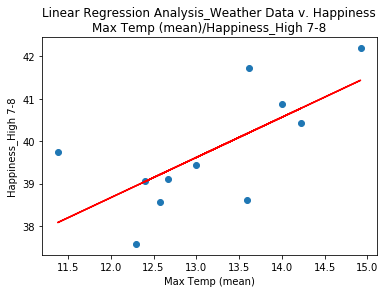

In [1669]:
# Plot the result (shown as red line)
plt.scatter(df_regr_sort.iloc[:,0:1],df_regr_sort.iloc[:,7:8])
plt.plot(df_regr_sort.iloc[:,0:1],ypred, color='red')
plt.xlabel('Max Temp (mean)')
plt.ylabel('Happiness_High 7-8')
plt.title('Linear Regression Analysis_Weather Data v. Happiness\nMax Temp (mean)/Happiness_High 7-8')

In [1661]:
# Use the built in predict method
ypred2=reg.predict(df_regr_sort.iloc[:,0:1])

Text(0.5, 1.0, 'Linear Regression Analysis_Weather Data v. Happiness\nMax Temp (mean)/Happiness_High 7-8')

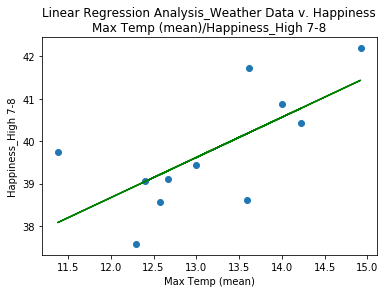

In [1668]:
# Plot the results (same as above, shown as green line)
plt.scatter(df_regr_sort.iloc[:,0:1],df_regr_sort.iloc[:,7:8])
plt.plot(df_regr_sort.iloc[:,0:1],ypred2, color='green')
plt.xlabel('Max Temp (mean)')
plt.ylabel('Happiness_High 7-8')
plt.title('Linear Regression Analysis_Weather Data v. Happiness\nMax Temp (mean)/Happiness_High 7-8')